In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

TensorFlow 1.x selected.


In [ ]:
!git clone https://github.com/hiddenmaze/InteractivePickup.git InteractivePickup --origin upstream

Cloning into 'InteractivePickup'...
remote: Enumerating objects: 5281, done.
remote: Total 5281 (delta 0), reused 0 (delta 0), pack-reused 5281
Receiving objects: 100% (5281/5281), 221.05 MiB | 14.01 MiB/s, done.
Resolving deltas: 100% (2788/2788), done.
Checking out files: 100% (5468/5468), done.


In [ ]:
%cd /content/InteractivePickup

/content/InteractivePickup


In [ ]:
import numpy as np
from os.path import isfile, exists
from preprocess4HGN import preprocess

In [ ]:
import numpy as np
import random
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from os import listdir, remove
from os.path import isfile, join
from google_drive_downloader import GoogleDriveDownloader as gdd
import gzip
import gensim

def load_w2v(w2v_path):
    if isfile(w2v_path) == False:
        print("Start downloading Google Word2Vec data")
        gdd.download_file_from_google_drive(file_id='0B7XkCwpI5KDYNlNUTTlSS21pQmM',
                                            dest_path=w2v_path+'.gz',
                                            unzip=False)
        inF = gzip.open(w2v_path+'.gz', 'rb')
        outF = open(w2v_path, 'wb')
        outF.write( inF.read() )
        inF.close()
        outF.close()

        remove(w2v_path+'.gz')
    print("Start loading Google Word2Vec data")
    w2v_model = gensim.models.KeyedVectors.load_word2vec_format(w2v_path, binary=True)
    print("Finished loading Google Word2Vec data")

    return w2v_model

def QGN_organize_data(img_path):
    img_resize = 64
    img_files = [f for f in listdir(img_path) if isfile(join(img_path, f))]

    total_images = dict()
    for f in img_files:
        tmp_img = io.imread(join(img_path, f))
        tmp_img = resize(tmp_img, [img_resize, img_resize], preserve_range=True)
        tmp_img = tmp_img / 255.0
        total_images[f[0:4]] = tmp_img
    
    return total_images
    
def HGN_organize_data(img_path, script_path):
    img_resize = 256
    heatmap_resize = 64
    
    img_files = [f for f in listdir(img_path) if isfile(join(img_path, f))]
    script_files = [f for f in listdir(script_path) if isfile(join(script_path, f))]

    total_images = dict()
    for f in img_files:
        tmp_img = io.imread(('%s/%s') % (img_path, f))
        tmp_img = resize(tmp_img, [img_resize, img_resize], preserve_range=True)
        tmp_img = tmp_img / 255.0
        total_images[f[0:4]] = tmp_img

    total_heatmaps = dict()
    for f in script_files:
        npzfile = np.load(('%s/%s') % (script_path, f))
        tmp_heatmap = npzfile['arr_0']
        tmp_heatmap = resize(tmp_heatmap, [heatmap_resize, heatmap_resize], preserve_range=True)
        total_heatmaps[f[0:12]] = tmp_heatmap
    return total_images, total_heatmaps
  
def divide_img_idx(img_idx, num_data):
    if isfile('./data/divide_img_idx.npz') == False:
        random_seed=1
        divide_rate=20

        tmp_img_idx = list(range(0,478))
        random.seed(random_seed)
        random.shuffle(tmp_img_idx)

        num_test_img = int((max(img_idx)+1)/divide_rate)
        test_img_idx = tmp_img_idx[0:num_test_img]
        train_img_idx = tmp_img_idx[num_test_img:len(tmp_img_idx)]

        np.savez('./data/divide_img_idx.npz', train_img_idx, test_img_idx)
    else:
        npzfile = np.load('./data/divide_img_idx.npz')
        train_img_idx = npzfile['arr_0']
        test_img_idx = npzfile['arr_1']
                               
    print('Test image index : %s' % (test_img_idx))

    return test_img_idx, train_img_idx
    
def get_test_idx(img_idx, num_data):
    test_img_idx, train_img_idx = divide_img_idx(img_idx, num_data)

    idx_whole = range(num_data)
    idx_test = []
    for i in test_img_idx:
        idx_test += np.where(img_idx == i)[0].tolist()
    idx_train = [i for i in idx_whole if i not in idx_test]
    
    return idx_test, idx_train

def QGN_divide_train_test(img_idx, sen_len, question_embeds, esti_maps, uncertainty_maps, answer_labels, num_data):
    idx_test, idx_train = get_test_idx(img_idx, num_data)

    num_train = len(idx_train)
    train_img_idx = img_idx[idx_train, :]
    train_sen_len = sen_len[idx_train, :]
    train_embeds = question_embeds[idx_train, :, :]
    train_esti = esti_maps[idx_train, :, :]
    train_uncertainty = uncertainty_maps[idx_train, :, :]
    train_answer_labels = answer_labels[idx_train, :]
    
    num_test = len(idx_test)
    test_img_idx = img_idx[idx_test, :]
    test_sen_len = sen_len[idx_test, :]
    test_embeds = question_embeds[idx_test, :, :]
    test_esti = esti_maps[idx_test, :, :]
    test_uncertainty = uncertainty_maps[idx_test, :, :]
    test_answer_labels = answer_labels[idx_test, :]

    print('Ended divided training and test dataset. Training : %d, Test : %d' % (num_train, num_test))                       
    
    return idx_train, idx_test, num_train, num_test,\
train_img_idx, train_sen_len, train_embeds,\
train_esti, train_uncertainty, train_answer_labels,\
test_img_idx, test_sen_len, test_embeds, test_esti, test_uncertainty, test_answer_labels
            
def HGN_divide_train_test(img_idx, sen_len, text_inputs, pos_outputs, num_data):
    idx_test, idx_train = get_test_idx(img_idx, num_data)

    num_train = len(idx_train)
    train_img_idx = img_idx[idx_train, :]
    train_sen_len = sen_len[idx_train, :]
    train_text_inputs = text_inputs[idx_train, :, :]
    train_pos_outputs = pos_outputs[idx_train, :]
    
    num_test = len(idx_test)    
    test_img_idx = img_idx[idx_test, :]
    test_sen_len = sen_len[idx_test, :]
    test_text_inputs = text_inputs[idx_test, :, :]
    test_pos_outputs = pos_outputs[idx_test, :]
    print('Ended divided training and test dataset. Training : %d, Test : %d' % (num_train, num_test))
    
    return idx_train, idx_test, num_train, num_test, \
           train_img_idx, train_sen_len, train_text_inputs, train_pos_outputs, \
           test_img_idx, test_sen_len, test_text_inputs, test_pos_outputs,
           

def load_test_img(img_path, curr_test_img_idx, img_resize, plot_flag):
    curr_test_img = np.zeros((1, img_resize, img_resize, 3))
    tmp_img = io.imread((img_path + '/%04d.jpg') % curr_test_img_idx)
    tmp_img = resize(tmp_img, [img_resize, img_resize], preserve_range=True)
    tmp_img = tmp_img / 255.0
    curr_test_img[0, :, :, :] = tmp_img

    if plot_flag == 1:
        plt.imshow(tmp_img)
        plt.show()
    
    return curr_test_img
    
def load_test_script(curr_test_input, vec, dim_sentence, max_step_sentence):
    curr_embed_input = np.zeros((1, dim_sentence, max_step_sentence))
    curr_seq_len = np.zeros((1, 1))
    curr_words = curr_test_input.split()
    for i, word in enumerate(curr_words):
        if word not in vec.keys():
            curr_embed_input[0, :, i] = np.zeros((100,))
        else:
            curr_embed_input[0, :, i] = vec[word]
    curr_seq_len[0, 0] = len(curr_words)

    print("Ready the test input script")
    
    return curr_embed_input, curr_seq_len

def plot_HGN_result(curr_test_input, curr_test_img, mean_of_esti, uncertainty, bound_u=0.0, bound_c=0.0):
    fig = plt.figure(figsize=(10, 10))
    fig.subplots_adjust(hspace=0.2, wspace=0.3)
    fig.suptitle('Input script: ' + curr_test_input, size=30)

    ax1 = fig.add_subplot(2, 2, 1)
    ax1.imshow(resize(curr_test_img[0, :, :, :], [256, 256], preserve_range=True))
    ax1.set_title('input image', size=20)
    ax1.set_axis_off()

    ax2 = fig.add_subplot(2, 2, 2)
    plot2 = ax2.imshow(resize(mean_of_esti, [256, 256], preserve_range=True), cmap='jet')
    ax2.set_title('estimation map', size=20)
    ax2.set_axis_off()
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(plot2, ax=ax2, cax=cax2)

    ax3 = fig.add_subplot(2, 2, 3)
    if bound_u > 0:
        norm3 = mpl.colors.Normalize(vmin=0, vmax=bound_u)
        plot3 = ax3.imshow(resize(uncertainty, [256, 256], preserve_range=True), cmap='jet',
                          norm = norm3)
    else:
        norm3 = mpl.colors.Normalize(vmin=0, vmax=np.max(uncertainty))
        plot3 = ax3.imshow(resize(uncertainty, [256, 256], preserve_range=True), cmap='jet',
                          norm = norm3)
    ax3.set_title('uncertainty map', size=20)
    ax3.set_axis_off()
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(plot3, ax=ax3, cax=cax3)   
    
    ax4 = fig.add_subplot(2, 2, 4)
    if bound_c > 0:
        norm4 = mpl.colors.Normalize(vmin=0, vmax=bound_c)
        plot4 = ax4.imshow(resize(2*uncertainty + mean_of_esti, [256, 256], preserve_range=True), cmap='jet', norm=norm4)
    else:
        norm4 = mpl.colors.Normalize(vmin=0, vmax=np.max(2*uncertainty + mean_of_esti))
        plot4 = ax4.imshow(resize(2*uncertainty + mean_of_esti, [256, 256], preserve_range=True), cmap='jet', norm=norm4) 
    ax4.set_title('confidence map', size=20)
    ax4.set_axis_off()
    divider4 = make_axes_locatable(ax4)
    cax4 = divider4.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(plot4, ax=ax4, cax=cax4)
    plt.savefig('/content/drive/MyDrive/machine_listening_2020/Project/{}.png'.format(curr_test_input))

In [ ]:
import tensorflow as tf

def convBlock(curr_input, numIn, numOut, dr_rate):
    net = tf.layers.batch_normalization(curr_input)
    net = tf.nn.relu(net)
    net = tf.layers.conv2d(net, int(numOut/2), 1, padding='Same')
    net = tf.layers.dropout(net, rate=dr_rate)
    net = tf.layers.batch_normalization(net)
    net = tf.nn.relu(net)
    net = tf.layers.conv2d(net, int(numOut/2), 3, padding='Same')
    net = tf.layers.dropout(net, rate=dr_rate)
    net = tf.layers.batch_normalization(net)
    net = tf.nn.relu(net)
    net = tf.layers.conv2d(net, numOut, 1, padding='Same')
    net = tf.layers.dropout(net, rate=dr_rate)

    return net

def skipLayer(curr_input, numIn, numOut, dr_rate):
    if numIn == numOut:
        return curr_input
    else:
        net = tf.layers.conv2d(curr_input, numOut, 1, padding='Same')
        net = tf.layers.dropout(net, rate=dr_rate)
        return net

def Residual(curr_input, numIn, numOut, dr_rate):
    curr_convBlock = convBlock(curr_input, numIn, numOut, dr_rate)
    curr_skipLayer = skipLayer(curr_input, numIn, numOut, dr_rate)
    return curr_convBlock + curr_skipLayer

In [ ]:
import tensorflow as tf
from tensorflow.python.ops import variable_scope as vs

stddev = 0.01

def hourglass_with_rnn(curr_input, rnn_feat, numDepth, numIn, numOut, dr_rate):
    up1 = curr_input
    up1 = Residual(up1, numIn, numOut, dr_rate)

    low1 = tf.layers.max_pooling2d(curr_input, 2, 2)
    low1 = Residual(low1, numIn, numOut, dr_rate)
    
    if numDepth > 1:
        low2 = hourglass_with_rnn(low1, rnn_feat, numDepth-1, numIn, numOut, dr_rate)
    else:
        low2 = Residual(low1, numIn, numOut, dr_rate)
    
    low3 = Residual(low2, numIn, numOut-1, dr_rate)
    
    with tf.variable_scope("word_weights", reuse=True):
        if numDepth == 4:
            _W_o4 = tf.get_variable('W_o4')
            _b_o4 = tf.get_variable('b_o4')
        elif numDepth == 3:
            _W_o3 = tf.get_variable('W_o3')
            _b_o3 = tf.get_variable('b_o3')
        elif numDepth == 2:
            _W_o2 = tf.get_variable('W_o2')
            _b_o2 = tf.get_variable('b_o2')
        elif numDepth == 1:
            _W_o1 = tf.get_variable('W_o1')
            _b_o1 = tf.get_variable('b_o1')
        else:
            raise ValueError('Code need to be fixed due to changed numDepth')
    
    if numDepth == 4:
        fitted_rnn = tf.matmul(rnn_feat, _W_o4)+_b_o4
    elif numDepth == 3:
        fitted_rnn = tf.matmul(rnn_feat, _W_o3)+_b_o3
    elif numDepth == 2:
        fitted_rnn = tf.matmul(rnn_feat, _W_o2)+_b_o2
    elif numDepth == 1:
        fitted_rnn = tf.matmul(rnn_feat, _W_o1)+_b_o1
    else:
        raise ValueError('Code need to be fixed due to changed numDepth')

    fitted_rnn = tf.nn.dropout(fitted_rnn, 1-dr_rate)
    
    fitted_rnn = tf.reshape(fitted_rnn, [tf.shape(rnn_feat)[0], 
                                        tf.to_int32(tf.sqrt(tf.to_float(tf.shape(fitted_rnn)[1]))),
                                        tf.to_int32(tf.sqrt(tf.to_float(tf.shape(fitted_rnn)[1])))])
    fitted_rnn = tf.expand_dims(fitted_rnn, axis=3)
    
    fuse_low3 = tf.concat([low3, fitted_rnn], axis=3)
        
    up2 = tf.image.resize_nearest_neighbor(fuse_low3, 2*tf.shape(fuse_low3)[1:3])

    return tf.add(up1, up2)


def lin(curr_input, numIn, numOut, dr_rate):
    l = tf.layers.conv2d(curr_input, numOut, 1, padding='Same')
    l = tf.layers.dropout(l, rate=dr_rate)
    l = tf.layers.batch_normalization(l)
    return tf.nn.relu(l)


def createModel(curr_img, curr_sen, curr_sen_len,
                img_size, dim_sentence, max_step_sentence, 
                num_hg_Depth, dim_hg_feat, dim_rnn_cell, dim_output,
                dr_rate):

    # image size must be 256 by 256.
    curr_rnn_encoder= rnn_encoder(img_size, num_hg_Depth, dim_sentence, max_step_sentence, dim_rnn_cell, dr_rate)
    
    rnn_feat = curr_rnn_encoder.encode(curr_sen, curr_sen_len)
    
    with vs.variable_scope('HGN'):
        with vs.variable_scope('pre'):
            cnv1 = tf.layers.conv2d(curr_img, filters=dim_hg_feat/4, kernel_size=7, strides=2, padding='Same')
            cnv1 = tf.layers.dropout(cnv1, rate=dr_rate)

            cnv1 = tf.layers.batch_normalization(cnv1)
            cnv1 = tf.nn.relu(cnv1)
        
        with vs.variable_scope('r1'):
            r1 = Residual(cnv1, dim_hg_feat/4, dim_hg_feat/2, dr_rate)

        pool = tf.layers.max_pooling2d(r1, 2, 2)

        with vs.variable_scope('r4'):    
            r4 = Residual(pool, dim_hg_feat/2, dim_hg_feat/2, dr_rate)

        with vs.variable_scope('r5'):    
            r5 = Residual(r4, dim_hg_feat/2, dim_hg_feat, dr_rate)    
    
        with vs.variable_scope('hg'):  
            hg = hourglass_with_rnn(r5, rnn_feat, num_hg_Depth, dim_hg_feat, dim_hg_feat, dr_rate)

        with vs.variable_scope('ll'):      
            ll = Residual(hg, dim_hg_feat, dim_hg_feat, dr_rate)
            ll = lin(ll, dim_hg_feat, dim_hg_feat, dr_rate)
            
        with vs.variable_scope('out'): 
            Out = tf.layers.conv2d(ll, filters=dim_output, kernel_size=1, strides=1, padding='Same')
            Out = tf.layers.dropout(Out, rate=dr_rate)
    
    return Out


class rnn_encoder(object):
    def __init__(self, img_size, hg_depth, dim_sentence, max_step_sentence, dim_rnn_cell, dr_rate):
        self.img_size = img_size
        self.hg_depth = hg_depth
        self.dim_sentence = dim_sentence
        self.max_step_sentence = max_step_sentence
        self.dim_rnn_cell = dim_rnn_cell
        self.dr_rate = dr_rate
        
        with tf.variable_scope("HGN/hg/word_weights"):                                              
            for i in range(hg_depth):
                exec('self.W_o%d = tf.get_variable('"'W_o%d'"', dtype=tf.float32,\
                                        initializer=tf.random_normal([self.dim_rnn_cell, \
                                                    int((self.img_size/(2**(self.hg_depth+1-%d)))**2)], \
                                                    stddev=stddev))' % (i+1, i+1, i+1))
                exec('self.b_o%d = tf.get_variable('"'b_o%d'"', dtype=tf.float32,\
                                       initializer=tf.random_normal([int((self.img_size/(2**(self.hg_depth+1-%d)))**2)], \
                                                                     stddev=stddev))' % (i+1, i+1, i+1))
    def encode(self, _x, _sen_len):
        _x_split = tf.transpose(_x, [2, 0, 1])
        _x_split = tf.reshape(_x_split, [-1, self.dim_sentence])
        _x_split = tf.split(_x_split, self.max_step_sentence, axis=0)

        with vs.variable_scope("HGN/rnn"):
            _rnn_cell = tf.nn.rnn_cell.BasicLSTMCell(self.dim_rnn_cell)
            _rnn_cell = tf.nn.rnn_cell.DropoutWrapper(_rnn_cell, output_keep_prob=1-self.dr_rate, input_keep_prob=1-self.dr_rate, state_keep_prob=1-self.dr_rate)
            _output, _state = tf.nn.static_rnn(_rnn_cell, _x_split, dtype=tf.float32, sequence_length=tf.squeeze(_sen_len))

        return _state[-1]

In [ ]:
import tensorflow as tf
import numpy as np

def define_model(dim_sentence, max_step_sentence, num_hg_Depth, dim_hg_feat, dim_rnn_cell):
    img_resize = 256
    heatmap_resize = 64

    ph_image = tf.placeholder(dtype=tf.float32, shape=[None, img_resize, img_resize, 3])
    ph_sen = tf.placeholder(dtype=tf.float32, shape=[None, dim_sentence, max_step_sentence])
    ph_sen_len = tf.placeholder(tf.int32, [None, 1])
    ph_dropout = tf.placeholder(tf.float32)
    
    result_heatmap = createModel(curr_img = ph_image,
                                 curr_sen = ph_sen,
                                 curr_sen_len = ph_sen_len,
                                 img_size = heatmap_resize, 
                                 dim_sentence = dim_sentence,
                                 max_step_sentence = max_step_sentence, 
                                 num_hg_Depth = num_hg_Depth,
                                 dim_hg_feat = dim_hg_feat,
                                 dim_rnn_cell = dim_rnn_cell,
                                 dim_output = 1,
                                 dr_rate = ph_dropout
                                )
    return result_heatmap, ph_image, ph_sen, ph_sen_len, ph_dropout
    
def session_run(result_heatmap, ph_image, ph_sen, ph_sen_len, ph_dropout,
                restore_path, curr_embed_input, curr_seq_len, curr_test_img):
    init = tf.global_variables_initializer()
    
    HGN_vars = [v for v in tf.trainable_variables() if v.name.startswith('HGN')]    

    saver = tf.train.Saver(var_list = HGN_vars)

    config = tf.ConfigProto()
    config.allow_soft_placement = True
    config.gpu_options.allow_growth = True

    T = 100

    with tf.Session(config=config) as sess:
        sess.run(init)

        saver.restore(sess, restore_path)

        test_feed_dict = {ph_sen: np.tile(curr_embed_input, (T, 1, 1)), 
                          ph_sen_len: np.tile(curr_seq_len, (T, 1)),
                          ph_image: np.tile(curr_test_img, (T, 1, 1, 1)), 
                          ph_dropout: 0.1}
        test_heatmap = sess.run(result_heatmap, feed_dict=test_feed_dict)

    test_heatmap = np.squeeze(test_heatmap)
    mean_of_esti = np.mean(test_heatmap, axis=0)
    mean_of_squared_esti = np.mean(test_heatmap**2, axis=0)
    squared_mean_of_esti = mean_of_esti ** 2
    uncertainty = np.sqrt(mean_of_squared_esti - squared_mean_of_esti)
    
    return mean_of_esti, uncertainty


In [ ]:
npzfile = np.load('/content/drive/MyDrive/machine_listening_2020/Project/train_model/preprocessed4HGN.npz')
img_idx = npzfile['arr_0']
text_inputs = npzfile['arr_2']

dim_sentence = text_inputs.shape[1]
max_step_sentence = text_inputs.shape[2]
num_data = img_idx.shape[0]

In [ ]:
result_heatmap, ph_image, ph_sen, ph_sen_len, ph_dropout= define_model(dim_sentence, 
                                                                       max_step_sentence, 
                                                                       num_hg_Depth = 4,
                                                                       dim_hg_feat = 256,
                                                                       dim_rnn_cell = 256)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Use keras.layers.MaxPooling2

In [ ]:
idx_test, idx_train = get_test_idx(img_idx, num_data)

Test image index : [154, 47, 59, 31, 419, 446, 217, 63, 152, 236, 289, 229, 434, 67, 45, 316, 352, 135, 285, 77, 318, 41, 142]


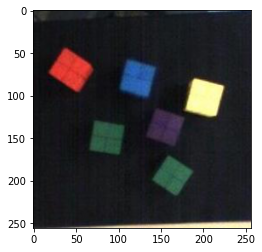

In [ ]:
test_img_idx = 117
img_path = './data/train_img'
curr_test_img = load_test_img(img_path, test_img_idx, img_resize=256, plot_flag = 1)

In [ ]:
import csv
import pandas as pd
contents = []

with open('/content/drive/MyDrive/machine_listening_2020/Project/train_model/speech_word2vec.txt', 'r') as f:
    vec_list = []
    for row in f:
        row2 = row.split()
        vec_list.append(row2)

In [ ]:
vec = pd.DataFrame(vec_list)
vec = vec.set_index(0).T.to_dict('list')

In [ ]:
curr_test_input = "pick up the upper right block"
curr_embed_input, curr_seq_len = load_test_script(curr_test_input, vec, 
                                                        dim_sentence, max_step_sentence)    
mean_of_esti, uncertainty = session_run(result_heatmap, ph_image, ph_sen, 
                                         ph_sen_len, ph_dropout,
                                         restore_path = "/content/drive/MyDrive/machine_listening_2020/Project/train_model/model_.ckpt",
                                         curr_embed_input = curr_embed_input,
                                         curr_seq_len = curr_seq_len,
                                         curr_test_img = curr_test_img)

Ready the test input script
INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/machine_listening_2020/Project/train_model/model_.ckpt


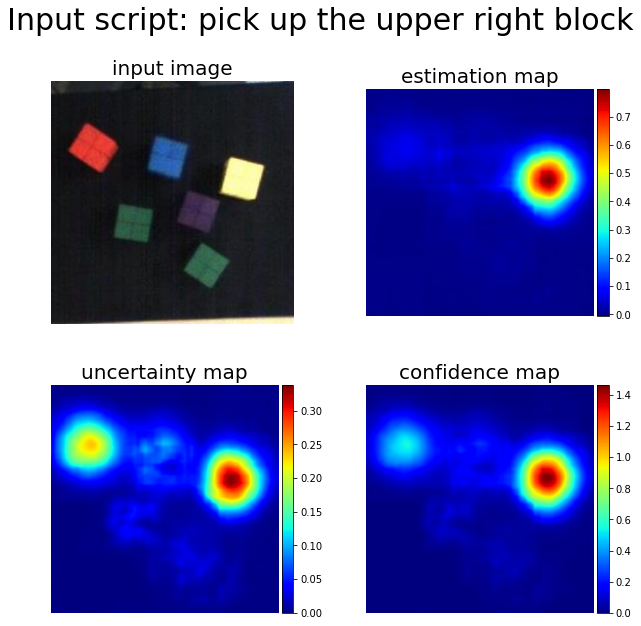

In [ ]:
plot_HGN_result(curr_test_input, curr_test_img, mean_of_esti, uncertainty)

In [ ]:
relative_data_directory_path = '/content/drive/MyDrive/machine_listening_2020/Project/train_model/preprocessed4HGN.npz'

data = np.load(relative_data_directory_path)

img_idx = data['arr_0']
seq_len = data['arr_1']
text_inputs = data['arr_2']
pos_outputs = data['arr_3']

dim_sentence = text_inputs.shape[1]
max_step_sentence = text_inputs.shape[2]
num_data = img_idx.shape[0]

In [ ]:
# Restore model

restore_path = '/content/drive/MyDrive/machine_listening_2020/Project/train_model/model_.ckpt'
init = tf.global_variables_initializer()
saver = tf.train.Saver()

config = tf.ConfigProto()
config.allow_soft_placement = True
config.gpu_options.allow_growth = True

T = 100

sess = tf.Session(config=config)
sess.run(init)
saver.restore(sess, restore_path)

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/machine_listening_2020/Project/train_model/model_.ckpt


In [ ]:
# Evaluate model

img_path = '/content/InteractivePickup/data/train_img'
dropout_rate = 0.1
num_test = len(idx_test)
num_correct = 0
correct_limit = 20 # 20 pixel (if the image size is 256x256)
error_idx = []
error = []

i=0
for idx in idx_test:
    print('Processing {}/{}'.format(i+1, num_test))
    i+=1
    test_img_idx = img_idx[idx, :]
    curr_test_img = load_test_img(img_path, test_img_idx, img_resize=256, plot_flag = 0)
    curr_embed_input = text_inputs[idx, :]
    curr_seq_len = seq_len[idx, :]
    curr_pos_outputs = pos_outputs[idx, :]
    
    
    test_feed_dict = {ph_sen: np.tile(curr_embed_input, (T, 1, 1)), 
                      ph_sen_len: np.tile(curr_seq_len, (T, 1)),
                      ph_image: np.tile(curr_test_img, (T, 1, 1, 1)),
                      ph_dropout: dropout_rate}
    test_heatmap = sess.run(result_heatmap, feed_dict=test_feed_dict)

    test_heatmap = np.squeeze(test_heatmap)
    mean_of_esti = np.mean(test_heatmap, axis=0)
    
    mean_of_esti = resize(mean_of_esti, [256, 256], preserve_range=True)
    pose_esti = np.unravel_index(np.argmax(mean_of_esti), mean_of_esti.shape)
    pose_esti = np.flip(pose_esti)
    
    distance = np.sqrt(np.sum((pose_esti - curr_pos_outputs)**2))
    if distance < correct_limit:
        num_correct += 1
    else:
        error_idx.append(idx)
        error.append(distance)

accuracy = (num_correct/num_test)*100
print('Speech2Vec accuracy: {}%'.format(accuracy))

Processing 1/1062
Processing 2/1062
Processing 3/1062
Processing 4/1062
Processing 5/1062
Processing 6/1062
Processing 7/1062
Processing 8/1062
Processing 9/1062
Processing 10/1062
Processing 11/1062
Processing 12/1062
Processing 13/1062
Processing 14/1062
Processing 15/1062
Processing 16/1062
Processing 17/1062
Processing 18/1062
Processing 19/1062
Processing 20/1062
Processing 21/1062
Processing 22/1062
Processing 23/1062
Processing 24/1062
Processing 25/1062
Processing 26/1062
Processing 27/1062
Processing 28/1062
Processing 29/1062
Processing 30/1062
Processing 31/1062
Processing 32/1062
Processing 33/1062
Processing 34/1062
Processing 35/1062
Processing 36/1062
Processing 37/1062
Processing 38/1062
Processing 39/1062
Processing 40/1062
Processing 41/1062
Processing 42/1062
Processing 43/1062
Processing 44/1062
Processing 45/1062
Processing 46/1062
Processing 47/1062
Processing 48/1062
Processing 49/1062
Processing 50/1062
Processing 51/1062
Processing 52/1062
Processing 53/1062
Pr